# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import cv2
import os

In [3]:
%tensorflow_version 2.x

### Change directory

In [4]:
os.chdir("/content/drive/My Drive/AIML/Colab_Notebook/Advanced Computer Vision/Internal_Lab")
os.getcwd()

'/content/drive/My Drive/AIML/Colab_Notebook/Advanced Computer Vision/Internal_Lab'

### Load the training data from train.csv file

In [5]:
os.listdir()

['images_racoon.rar',
 'train_labels.csv',
 'R9 - ACV - Internal_Lab_Questions.ipynb',
 'images']

In [6]:
df_rc = pd.read_csv("train_labels.csv")

### Print the shape of the train dataset

In [7]:
df_rc.shape

(173, 8)

In [8]:
df_rc.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [9]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [10]:
!pip install rarfile

In [11]:
import rarfile

In [12]:
with rarfile.RarFile('images_racoon.rar') as rf:
    rf.extractall()

In [13]:
imagepath = '/content/drive/My Drive/AIML/Colab_Notebook/Advanced Computer Vision/Internal_Lab/images/images'

In [14]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):        
        for j, r in enumerate(row): # Parse row with seven entities            
            if((j!= 0) & (j!=3)):
                row[j] = int(r)             
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)        
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [15]:
from PIL import Image
from tensorflow.keras.applications.mobilenet import preprocess_input

In [16]:
# batch_images = []
# for img in range(len(path)):
#   train_img = cv2.imread(path[img],)
#   train_img_resize = cv2.resize(train_img,(IMAGE_SIZE,IMAGE_SIZE))

#   batch_images.append(train_img_resize)

batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)

for i, fil in enumerate(paths):    
    img = Image.open('/content/drive/My Drive/AIML/Colab_Notebook/Advanced Computer Vision/Internal_Lab/images/images'+ '/' + fil)  
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Conv2D,Reshape


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [18]:
model = MobileNet(input_shape=(128, 128, 3), include_top=False) 
for layer in model.layers:
    layer.trainable = False
model1 = model.layers[-1].output
model1 = Conv2D(4, kernel_size=4)(model1)
model1 = Reshape((4,))(model1)

myModel = Model(inputs=model.input,outputs = model1)


In [19]:
myModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [20]:
import tensorflow as tf

In [21]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

In [22]:
# error for tf.py_func 
# iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
# replace tf.py_func (with) tf.compat.v1.py_func  (or) tf.py_function

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [23]:
from tensorflow.keras.backend import epsilon

In [24]:
myModel.compile(loss="mse", optimizer="adam", metrics=[IoU]) 
myModel.fit(batch_images, coords, epochs=30,
                    batch_size = 32,                                      
                    workers=7,
                    use_multiprocessing=True,
                    shuffle=True,
                    verbose=1) 

Epoch 1/30
6/6 [==============================] - 2s 273ms/step - loss: 3919.2681 - IoU: 0.0856
Epoch 2/30
6/6 [==============================] - 2s 278ms/step - loss: 708.2604 - IoU: 0.4344
Epoch 3/30
6/6 [==============================] - 2s 276ms/step - loss: 486.5363 - IoU: 0.5620
Epoch 4/30
6/6 [==============================] - 2s 273ms/step - loss: 613.9994 - IoU: 0.5428
Epoch 5/30
6/6 [==============================] - 2s 273ms/step - loss: 330.5301 - IoU: 0.6261
Epoch 6/30
6/6 [==============================] - 2s 271ms/step - loss: 183.4649 - IoU: 0.6662
Epoch 7/30
6/6 [==============================] - 2s 275ms/step - loss: 194.5093 - IoU: 0.6606
Epoch 8/30
6/6 [==============================] - 2s 277ms/step - loss: 154.9188 - IoU: 0.7007
Epoch 9/30
6/6 [==============================] - 2s 278ms/step - loss: 119.8412 - IoU: 0.7510
Epoch 10/30
6/6 [==============================] - 2s 274ms/step - loss: 113.9935 - IoU: 0.7500
Epoch 11/30
6/6 [==============================]

### Pick a test image from the given data

In [25]:
test_img = '/content/drive/My Drive/AIML/Colab_Notebook/Advanced Computer Vision/Internal_Lab/images/images/raccoon-167.jpg'
unscaled = cv2.imread(test_img)

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [26]:
image_height, image_width, chnl = unscaled.shape
image = cv2.resize(unscaled,(IMAGE_SIZE,IMAGE_SIZE))
# image = cv2.resize(unscaled,(128,128))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [27]:
region = myModel.predict(x=np.array([feat_scaled]))[0]

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

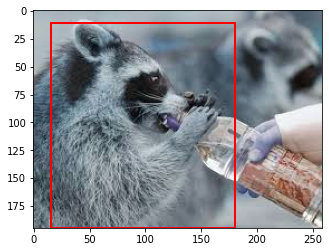

In [28]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()